# Vehicle Detection
by: Lucas Hagel

In [14]:
import numpy as np
import os, pickle, importlib, time, random, cv2, glob

from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from vehicle_detection_utilities import *


def show_images(image1, image2, image3, image4,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4"):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    ax3.imshow(image3)
    ax3.set_title(image3_exp, fontsize=20)
    ax4.imshow(image4)
    ax4.set_title(image4_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def bing():
    '''
    This function makes a sound - to be used when model training/testing is complete

    This is actually crucial for a busy person, start the NN training, and then this function
    is called (and makes the sound) when training's done
    '''
    pygame_spec = importlib.util.find_spec('pygame')
    if pygame_spec is not None:
        import pygame
        pygame.mixer.init()
        soundObj = pygame.mixer.Sound('beep1.ogg')
        soundObj.play()
        time.sleep(2)
        soundObj.stop()

### Classifier Code

In [6]:
########## get the NON cars ################
non_cdf1 = "./data_vehicles_renamed2/non-vehicles/Extras/*.png"
non_cdf2 = "./data_vehicles_renamed2/non-vehicles/GTI/*.png"

notcarpaths = []
for i in [non_cdf1, non_cdf2]:
    for im_path in glob.glob(i):
        notcarpaths.append(im_path)

######### get the CAAAAs    ###################

cdf1 = "./data_vehicles_renamed2/vehicles/GTI_Far/*.png"
cdf2 = "./data_vehicles_renamed2/vehicles/GTI_Left/*.png"
cdf3 = "./data_vehicles_renamed2/vehicles/GTI_Right/*.png"
cdf4 = "./data_vehicles_renamed2/vehicles/GTI_MiddleClose/*.png"

cdf5 = "./data_vehicles_renamed2/vehicles/KITTI_extracted/*.png"

carpaths = []
for i in [cdf1,cdf2,cdf3,cdf4,cdf5]:
    for im_path in glob.glob(i):
        carpaths.append(im_path)  

### Upload images and pickle 

In [8]:
t1=time.time()
'''

car_features    = [mpimg.imread(i) for i in carpaths]
notcar_features = [mpimg.imread(i)for i in notcarpaths]
car_features    = [get_img_features(i, **params_dict) for i in car_features]
notcar_features = [get_img_features(i, **params_dict) for i in notcar_features]

processed_training_data = [car_features,notcar_features]

with open("all_data_crcb.pickle","wb") as pklf:
    pickle.dump(processed_training_data, pklf)
'''
#other one is in
#all_data_crcb.pickle

with open("all_data_crcb.pickle",'rb') as infile:
    car_features,notcar_features = pickle.load(infile)

print("number of cars:",len(car_features))
print("Number of Non-cars",len(notcar_features))
t2 = time.time()
hogtime = round(t2-t1, 2)
print(round(t2-t1, 2), 'Seconds to extract HOG features...')


number of cars: 8792
Number of Non-cars 8968
0.43 Seconds to extract HOG features...


### Stack Features and Train the Linear SVM

In [9]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
   scaled_X, y, test_size=0.2, random_state=rand_state)

print("Feature length is ",len(car_features[0]) )

svc = LinearSVC()

t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')

# Check the score of the SVC
accuracy = round(svc.score(X_test, y_test), 4)
accuracystr = "%.4f" % accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Feature length is  8460
30.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9786


### Initial Car Recognition Function

In [10]:
def find_cars_maybe(input_img):
    '''
    Ideas from:https://github.com/tatsuyah/vehicle-detection/blob/master/vehicle-detection.ipynb
    As we get to higher y-values, we multiply ystop = ystart + 64 * scale 
    '''
    box_list2 = []
    box_list3 = []
    box_list4 = []
    box_list5 = []
    box_list6 = []
    box_list7 = []
    box_list8 = []
    box_list9 = []
    box_list10 = []
    box_list11 = []
    box_list12 = []
    ################  -- GOOD -- ###########        
    
    ystart = 400
    scale= 1
    ystop = int(ystart + 64*scale)
    box_list = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)  
    
    
    
    ystart = 410
    scale= 1.3
    ystop = int(ystart + 64*scale)+1
    box_list4 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)    
    
    '''ystart = 420
    scale= 1.5
    ystop = int(ystart + 64*scale)
    box_list6 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)'''
    ystart = 450
    scale= 1.8
    ystop = int(ystart + 64*scale)
    box_list7 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)
    ystart = 480
    scale= 1.8
    ystop = int(ystart + 64*scale)
    box_list8 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)
    ystart = 520
    scale= 2.2
    ystop = int(ystart + 64*scale)
    box_list9 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)
    
    ###########################
        
    box_list.extend(box_list2)
    box_list.extend(box_list3)
    box_list.extend(box_list4)
    box_list.extend(box_list5)
    box_list.extend(box_list6)
    box_list.extend(box_list7)
    box_list.extend(box_list8)
    box_list.extend(box_list9)
    box_list.extend(box_list10)
    box_list.extend(box_list11)
    box_list.extend(box_list12)
    #on_windows
    img = draw_boxes(input_img,box_list )
    return img, box_list

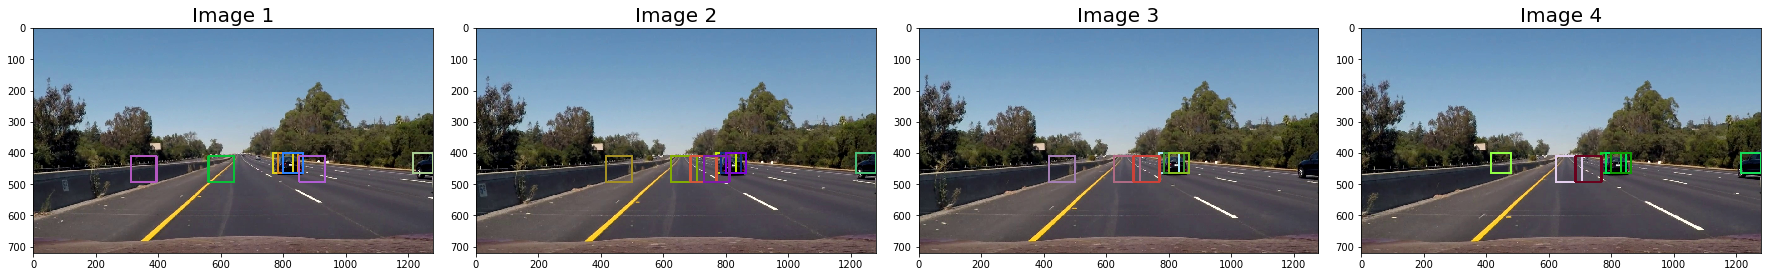

In [11]:
%matplotlib inline
#image1= find_cars_maybe(mpimg.imread("./samples/frame242.jpg") )[0]
#image2= find_cars_maybe(mpimg.imread("./samples/frame361.jpg"))[0]
#image3= find_cars_maybe(mpimg.imread("./samples/frame457.jpg"))[0]
#image4= find_cars_maybe(mpimg.imread("./samples/frame895.jpg"))[0]
image5= find_cars_maybe(mpimg.imread("./hell/frame1245.jpg"))[0]
image6= find_cars_maybe(mpimg.imread("./hell/frame1246.jpg"))[0]
image7= find_cars_maybe(mpimg.imread("./hell/frame1247.jpg"))[0]
image8= find_cars_maybe(mpimg.imread("./hell/frame1248.jpg"))[0]

#show_images(image1, image2, image3, image4,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4")
show_images(image5, image6, image7, image8,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4")

In [ ]:
image5= find_cars_maybe(mpimg.imread("./hell/frame165.jpg"))[0]
image6= find_cars_maybe(mpimg.imread("./hell/frame1193.jpg"))[0]
image7= find_cars_maybe(mpimg.imread("./hell/frame740.jpg"))[0]
image8= find_cars_maybe(mpimg.imread("./hell/frame550.jpg"))[0]

show_images(image5, image6, image7, image8,  image1_exp="Image 5", image2_exp="Image 6", image3_exp="Image 7", image4_exp="Image 8")

### Thresholding, Generating the Heatmap, and Outputting the Image 

In [12]:
from collections import deque
from scipy.ndimage.measurements import label
heatmap_que = deque(maxlen=10)

In [13]:
def add_heat(heatmap, bbox_list):        
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1            
    return heatmap
    
def apply_threshold(threshold,heatmap):
    '''
    
    Applies the threshold to the heatmap
    
    '''
    checkmap = np.copy(heatmap)
    checkmap[checkmap <= threshold] = 0        
    return checkmap
    
def generate_heatmap(image,box_list):
        '''
        Generates the heatmap
        
        adds heatmaps and then averages the results
        
        '''
        global heatmap_que        
        
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float64)       
        
        heatmap = add_heat(heatmap, box_list)
        
        heatmap = apply_threshold(1,heatmap) 
                
        heatmap = heatmap
        
        heatmap_que.append(heatmap)
        
        the_avg = np.array(heatmap_que).mean(axis=0)
        
        the_avg = apply_threshold(2, the_avg)
        return the_avg

def draw_labeled_bboxes(img, thresholded_image):
    '''
    Legend has it thresholded_image is a heatmap
    '''
    labels = label(thresholded_image)
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

def pipeline(image):
    imgi, box_listi = find_cars_maybe(image)    
    hmap = generate_heatmap(imgi, box_listi )    
    output_image = draw_labeled_bboxes(image,hmap)    
    return image

### Video Output Processing

In [ ]:

heatmap_que.clear()

from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'some22_29.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.subclip(22,24)
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)
bing()

In [ ]:
def show_images(image1, image2,   image1_exp="Image 1", image2_exp="Image 2",filename="tacos"):
    #this function was found from the internet, it was better than my Advanced Lane Lines image printer
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=17)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=17)    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig( "./examples/" + filename )

In [ ]:
veh = mpimg.imread("./data_vehicles_renamed2/vehicles/KITTI_extracted/11.png")
vehgray = cv2.cvtColor(np.copy(veh),cv2.COLOR_RGB2GRAY )
features13, hog_image_veh = get_hog_features(vehgray, 9, 8, 2, vis=True, feature_vec=True)

notveh = mpimg.imread("./data_vehicles_renamed2/non-vehicles/Extras/extra9.png")
notvehgray = cv2.cvtColor(np.copy(notveh),cv2.COLOR_RGB2GRAY )
features14, hog_imagenveh = get_hog_features(notvehgray, 9, 8, 2, vis=True, feature_vec=True)

show_images(veh, hog_image_veh, "Car", "HOG Features", "car-hog.jpg")
show_images(notveh, hog_imagenveh, "Non Car", "HOG Features", "non-car-hog.jpg")